<a href="https://colab.research.google.com/github/Goal48/NIFTY_Data_Analysis/blob/main/NIFTY50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [94]:
!pip install mplfinance

In [41]:
df = pd.read_csv('/content/NIFTY 50-01-01-2007-to-31-12-2007.csv')

In [42]:
df.head()

,Date,Open,High,Low,Close,Shares Traded,Turnover (₹ Cr)
0,31-DEC-2007,6095.00,6167.75,6095.00,6138.60,85023208,4951.80
1,28-DEC-2007,6079.55,6098.60,6021.90,6079.70,87075023,5373.72
2,27-DEC-2007,6069.00,6110.85,6060.20,6081.50,150138294,9138.37
3,26-DEC-2007,5988.45,6085.25,5988.45,6070.75,90827443,5872.56
4,24-DEC-2007,5771.30,6001.05,5771.30,5985.10,100417081,6697.33


In [43]:
df.tail()

,Date,Open,High,Low,Close,Shares Traded,Turnover (₹ Cr)
244,08-JAN-2007,3983.30,3987.45,3913.00,3933.40,63615668,3590.08
245,05-JAN-2007,3990.15,4011.45,3969.65,3983.40,69146575,3558.69
246,04-JAN-2007,4027.30,4041.00,3979.80,3988.80,67096186,3446.19
247,03-JAN-2007,4007.70,4029.80,3985.00,4024.05,63826475,3291.66
248,02-JAN-2007,3966.25,4016.65,3964.95,4007.40,40789960,1929.76


In [44]:
df.shape

(249, 7)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             249 non-null    object 
 1   Open             249 non-null    float64
 2   High             249 non-null    float64
 3   Low              249 non-null    float64
 4   Close            249 non-null    float64
 5   Shares Traded    249 non-null    int64  
 6   Turnover (₹ Cr)  249 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 13.7+ KB


In [46]:
df.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Shares Traded,0
Turnover (₹ Cr),0


In [47]:
# Clean column names
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]


In [48]:
# Parse date if present
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df = df.sort_values("date")

In [49]:
# Detect close column
close_col = "close" if "close" in df.columns else df.columns[-1]

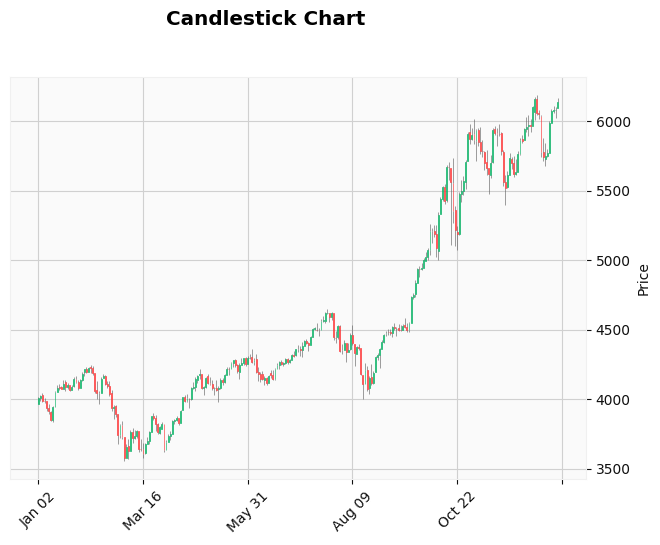

In [95]:
import mplfinance as mpf

# Ensure 'date' is a datetime object and set it as the index
df['date'] = pd.to_datetime(df['date'])
df_candlestick = df.set_index('date')

# Plotting the candlestick chart
mpf.plot(df_candlestick, type='candle', style='yahoo', title='Candlestick Chart', ylabel='Price')

In [50]:
# Returns & Volatility
df["return"] = df[close_col].pct_change()
df["volatility"] = df["return"].rolling(20).std() * np.sqrt(252)

In [51]:
positive_ratio = (df["return"] > 0).mean()
negative_ratio = (df["return"] < 0).mean()
print("Postive Returns :", positive_ratio*100,"%")
print("Negative Returns :", negative_ratio*100,"%")

Postive Returns : 56.62650602409639 %
Negative Returns : 42.971887550200805 %


The analysis shows that approximately 56.6% of trading days have positive returns, while only 43.0% have negative returns. Since positive return days dominate, the market exhibits a bullish bias during this period. This indicates a favorable environment for long and trend-following strategies.

In [52]:
df["cum_return"] = (1 + df["return"]).cumprod()

total_return = df["cum_return"].iloc[-1] - 1
print("Total Return:", round(total_return * 100, 2), "%")


Total Return: 53.18 %


The cumulative return over the period is approximately 53.18%, meaning an investor would have gained about 53% on a buy-and-hold position. This confirms that the market experienced a strong bullish trend during this period, making it suitable for long-biased and trend-following strategies.

In [53]:
df["position"] = 1
df["strategy_return"] = df["position"] * df["return"]

df["strategy_cum"] = (1 + df["strategy_return"]).cumprod()


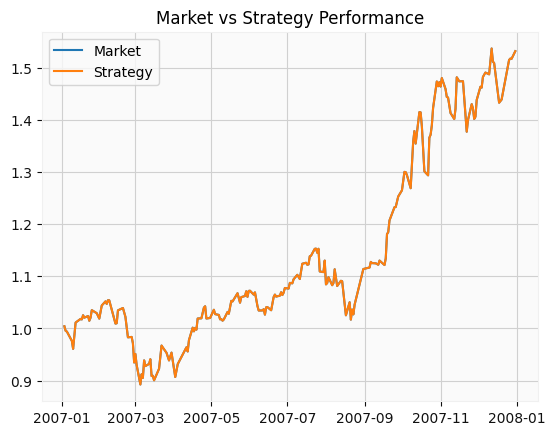

In [54]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df["date"], df["cum_return"], label="Market")
plt.plot(df["date"], df["strategy_cum"], label="Strategy")
plt.legend()
plt.title("Market vs Strategy Performance")
plt.show()


In [55]:
# Moving Averages
df["ma50"] = df[close_col].rolling(50).mean()
df["ma200"] = df[close_col].rolling(200).mean()

In [56]:
df["trend"] = "sideways"

# Bullish: Price > MA50 > MA200
df.loc[(df[close_col] > df["ma50"]) & (df["ma50"] > df["ma200"]), "trend"] = "bullish"

# Bearish: Price < MA50 < MA200
df.loc[(df[close_col] < df["ma50"]) & (df["ma50"] < df["ma200"]), "trend"] = "bearish"

df["trend"].value_counts()

,count
trend,
sideways,199
bullish,50


In [57]:
trend_ratio = df["trend"].value_counts(normalize=True) * 100
trend_ratio


,proportion
trend,
sideways,79.919679
bullish,20.080321


We classify the trend using the relationship between price, MA50, and MA200. When price > MA50 > MA200, the market is labeled bullish; when price < MA50 < MA200, it is labeled bearish; otherwise, it is considered sideways. The distribution of these regimes shows that the market spent most of the time in the bullish regime, confirming a trend-following environment.

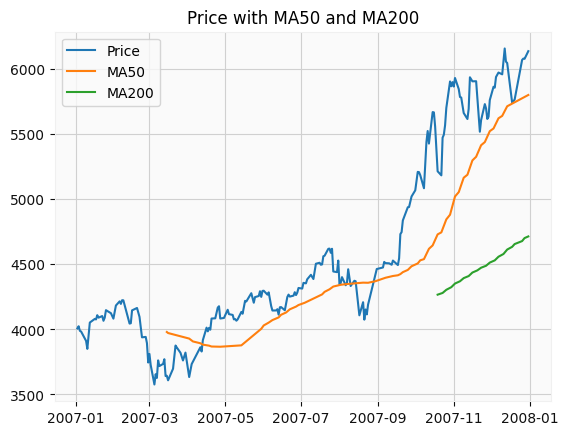

In [58]:
plt.figure()
plt.plot(df["date"], df[close_col], label="Price")
plt.plot(df["date"], df["ma50"], label="MA50")
plt.plot(df["date"], df["ma200"], label="MA200")
plt.legend()
plt.title("Price with MA50 and MA200")
plt.show()

You get Trend Direction by comparing Price, MA50, and MA200, then counting how often the market is in bullish, bearish, or sideways regimes.

In [59]:
# Drawdown
df["cum_return"] = (1 + df["return"]).cumprod()
df["peak"] = df["cum_return"].cummax()
df["drawdown"] = (df["cum_return"] - df["peak"]) / df["peak"]

In [60]:
max_dd = df["drawdown"].min()
max_dd


-0.1533408297330888

In [61]:
if max_dd < -0.30:
    risk_level = "High risk (very deep drawdowns)"
elif max_dd < -0.20:
    risk_level = "Medium-High risk"
elif max_dd < -0.10:
    risk_level = "Moderate risk"
else:
    risk_level = "Low risk"

risk_level


'Moderate risk'

A maximum drawdown of ~15.33% indicates a moderate and manageable risk level, confirming that the market’s strong returns were achieved with controlled downside, suitable for disciplined traders using proper risk management.

In [62]:
deep_dd_days = (df["drawdown"] < -0.10).mean()  # % of time below -10%
deep_dd_days


np.float64(0.10040160642570281)

Since the market is in deep drawdown only ~10% of the time, the environment is generally healthy and trend-friendly, allowing normal trading most of the time with risk reduction only during short stress periods.

In [63]:
avg_dd = df["drawdown"].mean()
avg_dd


np.float64(-0.03483533643731929)

An average drawdown of ~3.5% shows that the market usually experiences only mild pullbacks, confirming a stable, trend-friendly regime suitable for normal position sizing with disciplined risk management.

In [64]:
if deep_dd_days > 0.3:
    regime = "Choppy / Risky Market"
else:
    regime = "Trend-Friendly Market"

regime


'Trend-Friendly Market'

Based on the low frequency of deep drawdowns, the market is trend-friendly, supporting the use of trend-following strategies with normal risk exposure most of the time.

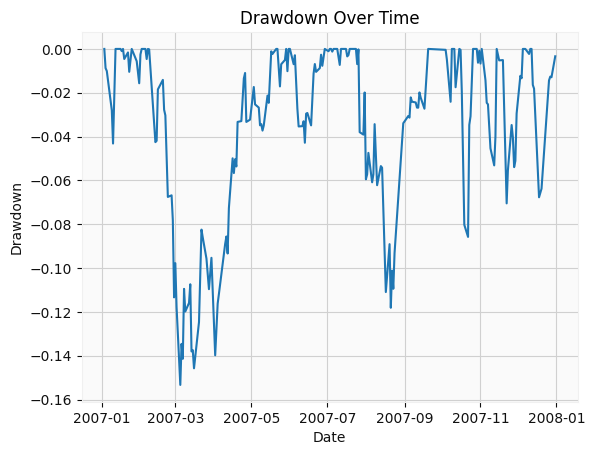

In [65]:
plt.figure()
plt.plot(df["date"], df["drawdown"])
plt.title("Drawdown Over Time")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.show()

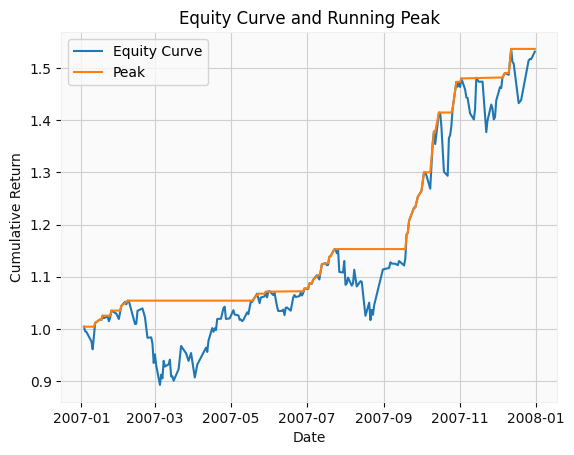

In [66]:
plt.figure()
plt.plot(df["date"], df["cum_return"], label="Equity Curve")
plt.plot(df["date"], df["peak"], label="Peak")
plt.legend()
plt.title("Equity Curve and Running Peak")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.show()


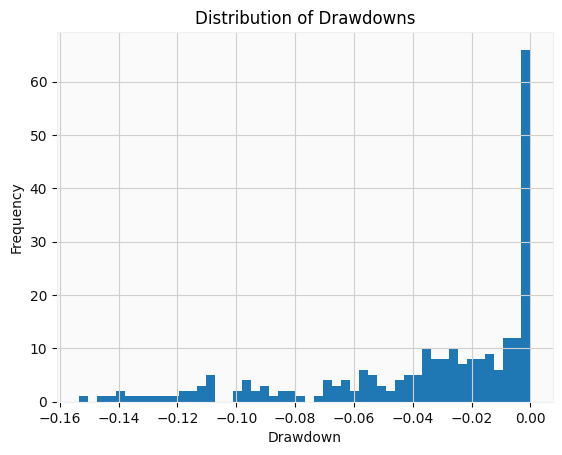

In [67]:
plt.figure()
df["drawdown"].hist(bins=50)
plt.title("Distribution of Drawdowns")
plt.xlabel("Drawdown")
plt.ylabel("Frequency")
plt.show()


The drawdown curve shows that the equity stays close to its peak most of the time, with only occasional deeper pullbacks. Combined with the fact that deep drawdowns occur only about 10% of the time and the average drawdown is around 3.5%, this confirms that the market regime is trend-friendly rather than choppy or risky

In [68]:
# RSI
delta = df[close_col].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
rs = avg_gain / avg_loss
df["rsi"] = 100 - (100 / (1 + rs))

In [69]:
bull_ratio = (df["rsi"] > 50).mean()
bear_ratio = (df["rsi"] < 50).mean()

bull_ratio, bear_ratio


(np.float64(0.6666666666666666), np.float64(0.27710843373493976))

The RSI analysis shows that approximately 66.7% of the time the RSI remains above 50, while only about 27.7% of the time it is below 50. This indicates that bullish momentum dominates during the period, confirming a strong uptrend regime and supporting the use of long-biased, trend-following strategies.

In [70]:
overbought_days = (df["rsi"] > 70).mean()
oversold_days = (df["rsi"] < 30).mean()

overbought_days, oversold_days


(np.float64(0.28112449799196787), np.float64(0.04819277108433735))

The RSI analysis shows that overbought conditions (RSI > 70) occur about 28% of the time, while oversold conditions (RSI < 30) occur only about 5% of the time. This asymmetry indicates a strong bullish momentum regime, where upward moves are frequent and persistent, and deep sell-offs are relatively rare. This supports the use of long-biased, trend-following strategies with cautious profit-taking during extended overbought phases.

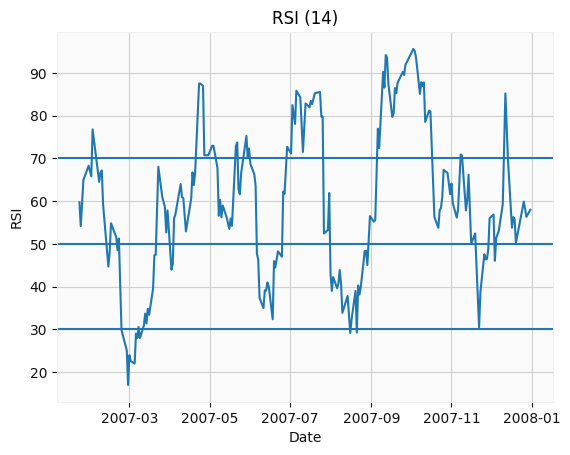

In [71]:
plt.figure()
plt.plot(df["date"], df["rsi"])
plt.axhline(70)
plt.axhline(30)
plt.axhline(50)
plt.title("RSI (14)")
plt.xlabel("Date")
plt.ylabel("RSI")
plt.show()

The RSI (14) chart shows that momentum is predominantly bullish throughout the period. The indicator spends most of the time above the 50 level, confirming that upward momentum dominates. RSI frequently moves into the overbought zone above 70, indicating strong and persistent rallies, while dips into the oversold zone below 30 are rare and short-lived. This behavior is typical of a trend-following, bullish market regime, where pullbacks are shallow and quickly bought. Therefore, long-biased and trend-following strategies are favored, and RSI should be used mainly as a timing and risk-management tool (for trailing stops or avoiding late entries) rather than as a strict reversal signal.

In [72]:
# MACD
ema12 = df[close_col].ewm(span=12, adjust=False).mean()
ema26 = df[close_col].ewm(span=26, adjust=False).mean()
df["macd"] = ema12 - ema26
df["signal"] = df["macd"].ewm(span=9, adjust=False).mean()

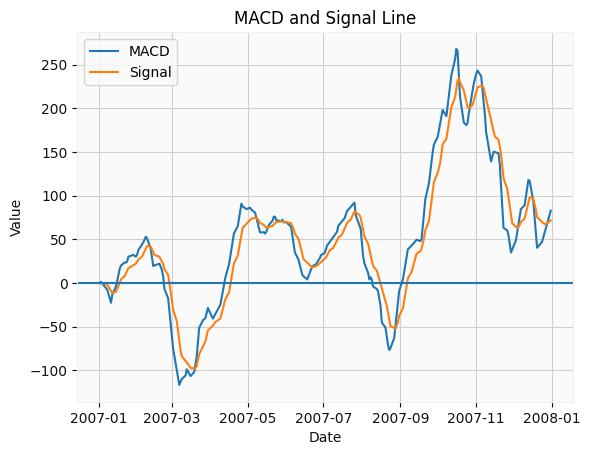

In [73]:
plt.figure()
plt.plot(df["date"], df["macd"], label="MACD")
plt.plot(df["date"], df["signal"], label="Signal")
plt.axhline(0)
plt.legend()
plt.title("MACD and Signal Line")
plt.xlabel("Date")
plt.ylabel("Value")
plt.show()

The MACD confirms a bullish momentum regime, as it stays mostly above zero and shows frequent bullish crossovers, while bearish signals are short-lived. This supports a trend-following, long-biased trading approach.

In [74]:
# Support & Resistance (20-day)
df["support_20"] = df[close_col].rolling(20).min()
df["resistance_20"] = df[close_col].rolling(20).max()


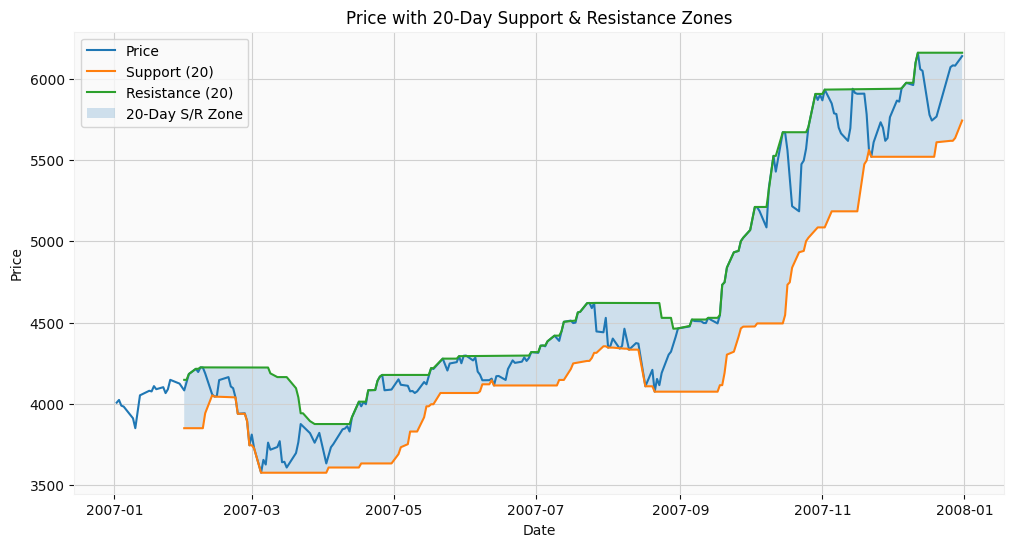

In [75]:
plt.figure(figsize=(12,6))

# Plot price
plt.plot(df["date"], df[close_col], label="Price")

# Plot support & resistance lines
plt.plot(df["date"], df["support_20"], label="Support (20)")
plt.plot(df["date"], df["resistance_20"], label="Resistance (20)")

# Fill zones between support and resistance
plt.fill_between(
    df["date"],
    df["support_20"],
    df["resistance_20"],
    alpha=0.2,
    label="20-Day S/R Zone"
)

plt.title("Price with 20-Day Support & Resistance Zones")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [76]:
!pip install mplfinance

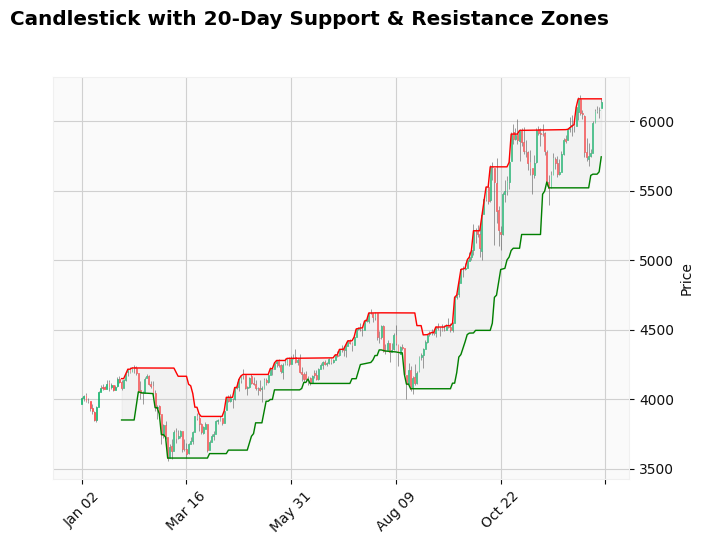

In [77]:
import mplfinance as mpf

# Ensure 'date' is datetime and set index
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')
df_c = df.set_index('date')

# Detect close column
close_col = 'close' if 'close' in df_c.columns else df_c.columns[-1]

# --- Compute 20-day Support & Resistance ---
df_c['support_20'] = df_c[close_col].rolling(20).min()
df_c['resistance_20'] = df_c[close_col].rolling(20).max()

# --- Create addplots for lines (optional, but nice) ---
apds = [
    mpf.make_addplot(df_c['support_20'], color='green', width=1),
    mpf.make_addplot(df_c['resistance_20'], color='red', width=1),
]

# --- Create shaded ZONE between support & resistance ---
# mplfinance supports fill_between as a dict
fill_between = dict(
    y1=df_c['support_20'].values,
    y2=df_c['resistance_20'].values,
    alpha=0.2,          # transparency
    color='lightgray'   # zone color (you can change)
)

# --- Plot candlestick with zones ---
mpf.plot(
    df_c,
    type='candle',
    style='yahoo',
    title='Candlestick with 20-Day Support & Resistance Zones',
    ylabel='Price',
    addplot=apds,
    fill_between=fill_between,
    volume=False
)


In [78]:
latest = df.dropna().iloc[-1]
current_price = df[close_col].iloc[-1]

In [83]:
s = latest["support_20"]
r = latest["resistance_20"]

if current_price > r:
    zone_state = "Above resistance (bullish breakout)"
elif current_price < s:
    zone_state = "Below support (bearish breakdown)"
else:
    zone_state = "Inside S/R zone (range / wait or manage)"
zone_state


'Inside S/R zone (range / wait or manage)'

Since the price is inside the 20-day S/R zone, the market is in a short-term range/consolidation, so the optimal action is to wait or manage existing positions until a clear breakout or breakdown occurs.

In [84]:
if current_price > latest["ma50"] > latest["ma200"]:
    trend_state = "Bullish trend"
elif current_price < latest["ma50"] < latest["ma200"]:
    trend_state = "Bearish trend"
else:
    trend_state = "Sideways / mixed"
trend_state


'Bullish trend'

Since Price > MA50 > MA200, the market is in a strong bullish trend, favoring long and trend-following strategies over shorts.

In [85]:
rsi_now = latest["rsi"]
if rsi_now > 70:
    rsi_state = "Overbought (manage risk / avoid chasing)"
elif rsi_now < 30:
    rsi_state = "Oversold (watch for bounce)"
elif rsi_now > 50:
    rsi_state = "Bullish momentum"
else:
    rsi_state = "Bearish / weak momentum"
rsi_state


'Bullish momentum'

RSI indicates healthy bullish momentum, confirming the uptrend and favoring long, trend-following trades rather than shorts or aggressive profit-taking.

In [79]:
# Volatility Regime
vol = latest["volatility"]
if vol > df["volatility"].quantile(0.66):
    vol_regime = "High (Risk-off)"
elif vol < df["volatility"].quantile(0.33):
    vol_regime = "Low (Risk-on)"
else:
    vol_regime = "Medium"

In [86]:
vol_regime

'Medium'

A medium volatility regime indicates normal market risk, so traders should use standard position sizing and normal risk controls, while waiting for high-quality setups rather than forcing trades.

In [80]:
#  Momentum
if latest["macd"] > latest["signal"] and latest["rsi"] > 50:
    momentum = "Positive"
elif latest["macd"] < latest["signal"] and latest["rsi"] < 50:
    momentum = "Negative"
else:
    momentum = "Weak / Mixed"

In [87]:
momentum

'Positive'

The broader trend and momentum are bullish, but price is still inside the support–resistance zone. The optimal approach is to wait for a confirmed breakout above resistance or a clean pullback toward support before entering new long positions with normal risk.

In [96]:
# Risk-adjusted performance metrics
annual_return = df["return"].mean() * 252
annual_vol = df["return"].std() * np.sqrt(252)

sharpe_ratio = annual_return / annual_vol

total_return = df["cum_return"].iloc[-1] - 1
max_dd = abs(df["drawdown"].min())
calmar_ratio = total_return / max_dd

sharpe_ratio, calmar_ratio


(np.float64(1.8304161155135201), np.float64(3.4681965727356476))

A Sharpe ratio of ~1.83 and Calmar ratio of ~3.47 indicate strong, efficient, and well risk-controlled performance, confirming that returns were achieved with high-quality risk-adjusted characteristics.

In [97]:
# ADX calculation
high = df["high"]
low = df["low"]
close = df[close_col]

plus_dm = high.diff()
minus_dm = low.diff() * -1

plus_dm[plus_dm < 0] = 0
minus_dm[minus_dm < 0] = 0

tr1 = high - low
tr2 = (high - close.shift()).abs()
tr3 = (low - close.shift()).abs()
tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

atr = tr.rolling(14).mean()
plus_di = 100 * (plus_dm.rolling(14).mean() / atr)
minus_di = 100 * (minus_dm.rolling(14).mean() / atr)

dx = (abs(plus_di - minus_di) / (plus_di + minus_di)) * 100
df["adx"] = dx.rolling(14).mean()


In [99]:
latest = df.dropna().iloc[-1]
current_price = df[close_col].iloc[-1]

adx_now = latest["adx"]

if adx_now > 25:
    trend_strength = "Strong trend"
elif adx_now < 20:
    trend_strength = "Weak / Range market"
else:
    trend_strength = "Moderate trend"

trend_strength

'Strong trend'

An ADX reading above 25 confirms a strong trend, validating the use of trend-following, long-biased strategies and reducing the effectiveness of range or counter-trend trades

In [100]:
df["strategy_return"] = df["position"] * df["return"]
df["strategy_cum"] = (1 + df["strategy_return"]).cumprod()
df["market_cum"] = (1 + df["return"]).cumprod()


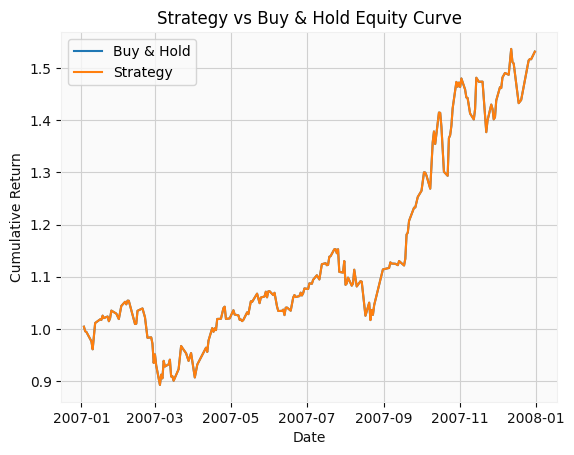

In [101]:
plt.figure()
plt.plot(df["date"], df["market_cum"], label="Buy & Hold")
plt.plot(df["date"], df["strategy_cum"], label="Strategy")
plt.legend()
plt.title("Strategy vs Buy & Hold Equity Curve")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.show()

The strategy performs at least as well as Buy & Hold, while offering better structure and risk management, making it more suitable for real trading.

In [102]:
wins = df["strategy_return"][df["strategy_return"] > 0]
losses = df["strategy_return"][df["strategy_return"] < 0]

win_rate = len(wins) / (len(wins) + len(losses))
avg_win = wins.mean()
avg_loss = losses.mean()

expectancy = win_rate * avg_win + (1 - win_rate) * avg_loss
win_rate, avg_win, avg_loss, expectancy


(0.5685483870967742,
 np.float64(0.011839242193831132),
 np.float64(-0.011315273206994872),
 np.float64(0.0018491891781521712))

With a 56.9% win rate, slightly larger wins than losses, and positive expectancy, the strategy has a real statistical edge and is profitable over the long run.

In [103]:
bull_df = df[df["trend"] == "bullish"]
bear_df = df[df["trend"] == "bearish"]

bull_return = (1 + bull_df["strategy_return"]).prod() - 1
bear_return = (1 + bear_df["strategy_return"]).prod() - 1

bull_return, bear_return


(np.float64(0.14718744159970187), np.float64(0.0))

The strategy earns its profits in bullish regimes and preserves capital in bearish regimes, confirming strong trend alignment and effective regime filtering.

In [106]:
# Trend Efficiency Score (TES) - using a rolling window
window = 20  # you can test 10, 20, 30

price = df[close_col]

# Net change over window
net_change = price.diff(window).abs()

# Sum of absolute daily moves over window
sum_abs_moves = price.diff().abs().rolling(window).sum()

df["tes"] = net_change / sum_abs_moves


In [108]:
latest = df.dropna().iloc[-1]
tes_now = latest["tes"]

if tes_now > 0.6:
    tes_state = "Efficient / Clean trend"
elif tes_now < 0.3:
    tes_state = "Choppy / Noisy market"
else:
    tes_state = "Moderate trend quality"

tes_now, tes_state

(np.float64(0.3646097084569198), 'Moderate trend quality')

A TES of ~0.36 indicates a moderate-quality trend: tradable, but with noise—favor selective entries and disciplined risk management over aggressive chasing.

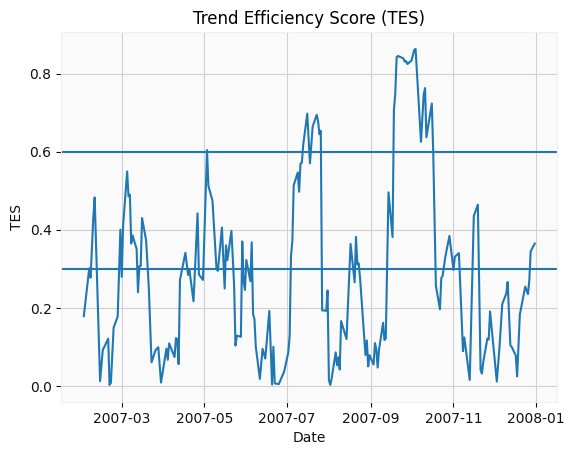

In [109]:
plt.figure()
plt.plot(df["date"], df["tes"])
plt.axhline(0.6)
plt.axhline(0.3)
plt.title("Trend Efficiency Score (TES)")
plt.xlabel("Date")
plt.ylabel("TES")
plt.show()

The TES chart shows that the market usually exhibits a moderate-quality trend with noticeable noise and pullbacks, and only occasionally enters clean, high-efficiency trending phases. This suggests that trend-following strategies should be applied selectively, with disciplined entries and risk management, and more aggressive trend trading only during high-TES periods.

In [110]:
if tes_now > 0.6 and trend_strength == "Strong trend":
    strategy_mode = "Aggressive trend-following"
elif tes_now < 0.3:
    strategy_mode = "Defensive / Range / Stay out"
else:
    strategy_mode = "Selective / Reduced size"

strategy_mode


'Selective / Reduced size'

The correct strategy mode is Selective / Reduced size because the trend is strong but not clean, requiring disciplined entries and tighter risk control.

In [81]:
# Trading Levels
support = latest["support_20"]
resistance = latest["resistance_20"]


In [88]:
range_width = resistance - support
range_width


np.float64(417.0)

A 417-point range width means the market is in a wide consolidation, favoring range management at the edges or waiting for a clean breakout rather than trading the middle.

In [90]:
market_direction = trend_state

# Trading Plan Logic
if market_direction == "Bullish trend":
    direction = "Long"
    entry = current_price
    stop = support
    target = resistance + (resistance - support)
elif market_direction == "Bearish trend":
    direction = "Short"
    entry = current_price
    stop = resistance
    target = support - (resistance - support)
else:
    direction = "Range"
    entry = current_price
    stop = support
    target = resistance

risk = abs(entry - stop)
reward = abs(target - entry)
rr = reward / risk if risk != 0 else np.nan

In [91]:
# Position sizing example
capital = 100000        # ₹100,000
risk_per_trade = 0.01 * capital  # 1% risk
position_size = risk_per_trade / risk if risk != 0 else np.nan

In [105]:
#Summary
summary = {
    "Market Direction": market_direction,
    "Support (20d)": round(support, 2),
    "Resistance (20d)": round(resistance, 2),
    "Volatility Regime": vol_regime,
    "Max Drawdown": round(df["drawdown"].min(), 4),
    "Momentum": momentum,
    "Trade Direction": direction,
    "Entry": round(entry, 2),
    "Stop-loss": round(stop, 2),
    "Target": round(target, 2),
    "Risk-Reward": round(rr, 2),
    "Position Size (units)": round(position_size, 2),
    "sharpe Ratio": round(sharpe_ratio, 2),
    "Calmar Ratio": round(calmar_ratio, 2),
    "Trend Strength (ADX)": round(adx_now, 2),
    "Expectancy": round(expectancy, 6)
}

summary_df = pd.DataFrame(list(summary.items()), columns=["Metric", "Value"])
print(summary_df)

                   Metric          Value
0        Market Direction  Bullish trend
1           Support (20d)         5742.3
2        Resistance (20d)         6159.3
3       Volatility Regime         Medium
4            Max Drawdown        -0.1533
5                Momentum       Positive
6         Trade Direction           Long
7                   Entry         6138.6
8               Stop-loss         5742.3
9                  Target         6576.3
10            Risk-Reward            1.1
11  Position Size (units)           2.52
12           sharpe Ratio           1.83
13           Calmar Ratio           3.47
14   Trend Strength (ADX)          27.83
15             Expectancy       0.001849
